In [4]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2022-12-14 05:15:55--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  --.-KB/s    in 0.09s   

2022-12-14 05:15:55 (51.3 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay 

In [6]:
df = pd.read_csv("bbc_text_cls.csv")

In [7]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [8]:
df["targets"] = df["labels"].astype("category").cat.codes

In [9]:
K = df["targets"].max() + 1
K

5

In [10]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [11]:
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train["text"])
sequences_train = tokenizer.texts_to_sequences(df_train["text"])
sequences_test = tokenizer.texts_to_sequences(df_test["text"])

In [12]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(f"Found {V} unique tokens.")

Found 26883 unique tokens.


In [13]:
data_train = pad_sequences(sequences_train)
print(f"Shape of data train tensor {data_train.shape}")

T = data_train.shape[1]

Shape of data train tensor (1490, 3499)


In [14]:
data_test = pad_sequences(sequences_test, maxlen=T)
print(f"Sahpe of data test tensor {data_test.shape}")

Sahpe of data test tensor (735, 3499)


In [15]:
D = 50
i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation="relu")(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(64, 3, activation="relu")(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [16]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

ft = model.fit(
    data_train, df_train["targets"],
    validation_data=(data_test, df_test["targets"]),
    epochs=50
)

Epoch 1/50
47/47 [==============================] - 11s 223ms/step - loss: 1.5720 - accuracy: 0.3309 - val_loss: 1.5120 - val_accuracy: 0.5401
Epoch 2/50
47/47 [==============================] - 10s 216ms/step - loss: 1.3675 - accuracy: 0.7430 - val_loss: 1.2314 - val_accuracy: 0.8150
Epoch 3/50
47/47 [==============================] - 12s 251ms/step - loss: 0.9494 - accuracy: 0.8966 - val_loss: 0.7627 - val_accuracy: 0.8871
Epoch 4/50
47/47 [==============================] - 10s 218ms/step - loss: 0.5050 - accuracy: 0.9396 - val_loss: 0.4412 - val_accuracy: 0.9048
Epoch 5/50
47/47 [==============================] - 10s 216ms/step - loss: 0.2788 - accuracy: 0.9537 - val_loss: 0.3108 - val_accuracy: 0.9211
Epoch 6/50
47/47 [==============================] - 10s 218ms/step - loss: 0.1786 - accuracy: 0.9678 - val_loss: 0.2483 - val_accuracy: 0.9374
Epoch 7/50
47/47 [==============================] - 10s 217ms/step - loss: 0.1230 - accuracy: 0.9779 - val_loss: 0.2153 - val_accuracy: 0.9442

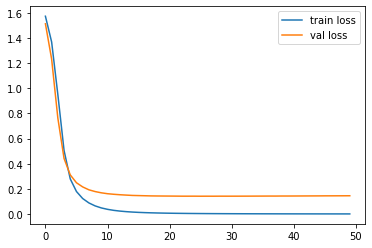

In [17]:
plt.plot(ft.history["loss"], label="train loss")
plt.plot(ft.history["val_loss"], label="val loss")
plt.legend();

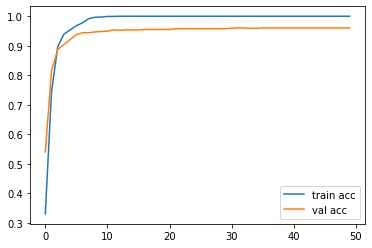

In [18]:
plt.plot(ft.history["accuracy"], label="train acc")
plt.plot(ft.history["val_accuracy"], label="val acc")
plt.legend();

In [19]:
Ptrain = np.argmax(model.predict(data_train), axis=1)
Ptest = np.argmax(model.predict(data_test), axis=1)

23/23 [==============================] - 2s 80ms/step


In [21]:
print(Ptrain)
cm = confusion_matrix(df_train["targets"], Ptrain)
cm

[0 0 2 ... 2 1 1]


array([[345,   0,   0,   0,   0],
       [  0, 256,   0,   0,   0],
       [  0,   0, 273,   0,   0],
       [  0,   0,   0, 349,   0],
       [  0,   0,   0,   0, 267]])

In [22]:
cm_test = confusion_matrix(df_test["targets"], Ptest)
cm_test

array([[155,   0,   5,   0,   5],
       [  1, 122,   4,   0,   3],
       [  3,   0, 139,   1,   1],
       [  1,   0,   0, 160,   1],
       [  1,   0,   3,   0, 130]])

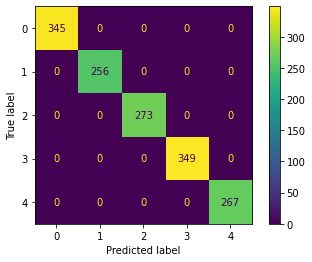

In [24]:
ConfusionMatrixDisplay.from_predictions(df_train["targets"], Ptrain);

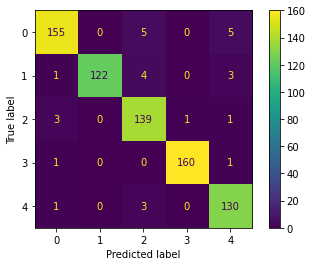

In [25]:
ConfusionMatrixDisplay.from_predictions(df_test["targets"], Ptest);